##### Imports

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import yaml
from JOPLEn.enums import CellModel
from JOPLEn.partitioner import VPartition
from JOPLEn.singletask import JOPLEn
from JOPLEn.st_loss import SquaredError
from JOPLEn.st_penalty import NuclearNorm, SquaredFNorm
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import wilcoxon
from sklearn.metrics import mean_squared_error

PRED_PATH = Path().resolve() / "ax_runs"
PLOT_PATH = Path().resolve() / "plots"
OUT_PATH = Path() / "manual"

##### Plot 1: Regression performance

In [2]:
skip_methods = {}

# We ran these experiments but can't show everything because of space constraints
skip_methods["regr"] = [
    "jp_linear_rf_inf",
    "jp_linear_gb_inf",
    "jp_linear_vor_inf",
    "jp_linear_linforest_inf",
    "jp_const_vor_l1",
    "jp_linear_vor_l1",
    "jp_const_linforest_l1",
    "jp_linear_linforest_l1",
    "jp_const_gb_l1",
    "jp_linear_gb_l1",
    "jp_const_rf_l1",
    "jp_linear_rf_l1",
    "jp_linear_gb_nn",
    "jp_const_gb_l2L2",
    "jp_const_linforest_l2L2",
    "jp_const_linforest_l2",
    "et",
    "rf_fr",
    "gb_fr",
    "xgboost",
    "lgbm",
]

skip_methods["class"] = [
    "jp_linear_rf_inf",
    "jp_linear_gb_inf",
    "jp_linear_vor_inf",
    "jp_linear_linforest_inf",
    "jp_const_vor_l1",
    "jp_linear_vor_l1",
    "jp_const_linforest_l1",
    "jp_linear_linforest_l1",
    "jp_const_gb_l1",
    "jp_linear_gb_l1",
    "jp_const_rf_l1",
    "jp_linear_rf_l1",
    "jp_linear_gb_nn",
    "jp_const_gb_l2L2",
    "jp_const_linforest_l2L2",
    "jp_const_linforest_l2",
    "et",
    "rf_fr",
    "gb_fr",
    "xgboost",
    "lgbm",
]

skip_methods["both"] = list(set(skip_methods["regr"]) & set(skip_methods["class"]))

In [3]:
# load regression results
reg_res = defaultdict(lambda: defaultdict(dict))
alt_reg_res = defaultdict(lambda: defaultdict(dict))

for task_type in PRED_PATH.iterdir():
    for method_dir in task_type.iterdir():
        if method_dir.is_dir():
            for dataset_dir in method_dir.iterdir():
                if dataset_dir.is_dir():
                    fp = dataset_dir / "metadata.yaml"

                    if not fp.exists():
                        continue

                    with open(fp, "r") as f:
                        tmp = yaml.safe_load(f)

                    if (
                        method_dir.name in skip_methods[task_type.name]
                        or method_dir.name in skip_methods["both"]
                    ):
                        alt_reg_res[task_type.name][method_dir.name][
                            dataset_dir.name
                        ] = tmp
                    else:
                        reg_res[task_type.name][method_dir.name][dataset_dir.name] = tmp


reg_res = {k: dict(v) for k, v in reg_res.items()}
alt_reg_res = {k: dict(v) for k, v in alt_reg_res.items()}

In [4]:
# only keep datasets shared by all methods
shared_datasets = defaultdict(lambda: defaultdict(set))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        for contains_categorical in [True, False, "postprocessed"]:
            keys = [
                k
                for k, v in datasets.items()
                if v["contains_categorical"] == contains_categorical
            ]

            if not shared_datasets[task_type][contains_categorical]:
                shared_datasets[task_type][contains_categorical] = set(keys)
            else:
                shared_datasets[task_type][contains_categorical] &= set(keys)

shared_datasets = {k: dict(v) for k, v in shared_datasets.items()}

new_reg_res = defaultdict(lambda: defaultdict(dict))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        for contains_categorical in [True, False, "postprocessed"]:
            new_reg_res[task_type][method].update(
                {
                    k: v
                    for k, v in datasets.items()
                    if k in shared_datasets[task_type][contains_categorical]
                }
            )

reg_res = {k: dict(v) for k, v in new_reg_res.items()}

In [5]:
def plot_strip(
    reg_res: dict,
    ax,
    colors: dict | None = None,
    jitter: float = 0.2,
    random_state: int = 0,
    # plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
    only_continuous: bool = False,
    # figsize: tuple | None = None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    def score(vv: dict, only_classification: bool):
        # print(vv)
        if only_classification:
            return vv["metadata"]["test"]["zo_loss"]
        else:
            return vv["test_score"] / vv["dummy_loss"]

    rescaled_res = {
        k: {
            kk: score(vv, only_classification)
            for kk, vv in v.items()
            if not (
                only_continuous
                and vv["contains_categorical"] in [True, "postprocessed"]
            )
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    median_res = {k: np.median(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {
        k: rescaled_res[k] for k in sorted(median_res, key=median_res.get)[::-1]
    }

    if colors is None:
        colors = [plt.cm.tab10(i) for i in range(len(sorted_dict))]
    else:
        colors = [plt.cm.tab10(colors[k]) for k in sorted_dict.keys()]

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, c=[colors[x_idx]] * len(val), **scatter_kwargs)

    x_lim = (0, max(ax.get_xlim()[1], 1.2))
    x_lim = (0, min(x_lim[1], 1 if only_classification else 1.5))

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    print("num_datasets:", len(list(rescaled_res.values())[0]))

    # plot vertical line for median for each model
    medians = [np.median(list(val)) for val in x_values]
    for x_value, median in zip(range(len(x_values)), medians):
        ax.vlines(median, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, medians)})

    ax.set_yticks(range(len(y_labels)))
    ax.tick_params(pad=80, axis="y")
    ax.set_yticklabels(y_labels, ha="left")

    if not only_classification:
        ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")

    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    ax.set_xlabel("Normalized MSE" if not only_classification else "0/1 Loss")

    # plt.tight_layout()

    return ax, medians, len(list(rescaled_res.values())[0]), list(sorted_dict.keys())


def compare_methods(method1, method2, pred_type):
    reg_res1 = reg_res[pred_type][method1]
    reg_res2 = reg_res[pred_type][method2]

    assert len(reg_res1) == len(reg_res2)

    method1, method2 = [], []

    for k, v in reg_res1.items():
        if k in reg_res2:
            v2 = reg_res2[k]

            if pred_type == "class":
                method1.append(v["metadata"]["test"]["zo_loss"])
                method2.append(v2["metadata"]["test"]["zo_loss"])
            else:
                method1.append(v["test_score"] / v["dummy_loss"])
                method2.append(v2["test_score"] / v2["dummy_loss"])

    return wilcoxon(method1, method2, alternative="less", method="exact").pvalue

In [6]:
part_colors = {
    "rf": 0,
    "gb": 1,
    "vor": 2,
    "cb": 3,
    "ridge": 4,
    "et": 5,
    "nn": 6,
    "fastel": 7,
    "xgboost": 8,
    "lf": 9,
    "linforest": 9,
    "ridgeforest": 9,
}

part_name = {
    "rf": "RF",
    "gb": "GB",
    "vor": "Vor",
    "cb": "CatBoost",
    "lf": "LF",
    "ridge": "Ridge",
    "et": "ET",
    "nn": "NN",
    "fastel": "FASTEL",
    "xgboost": "XGB",
    "linforest": "LF",
    "ridgeforest": "RidgeF",
}

penalty_name = {
    "nn": "Nuclear Norm",
    "l1": "$\ell_1$",
    "l2": "F",
    "l21": "$\ell_{2,1}$",
    "l2L2": "$\mathcal{L}$",
    "inf": "$\ell_\infty$",
}


def rename_and_color(reg_res: dict) -> tuple[dict, dict]:
    method_colors = {}
    method_names = {}

    for method in reg_res:
        split = method.split("_")

        match split:
            case (name,):  # raw model
                method_names[method] = f"{part_name[name]}"
                method_colors[method] = part_colors[name]
            case name, _:  # friedman refitting
                method_names[method] = f"{part_name[name]} (Friedman)"
                method_colors[method] = part_colors[name]
            case _, cell, name, penalty:  # joplen methods
                if cell == "linear":
                    method_names[method] = (
                        f"{part_name[name]} JOPLEN: {penalty_name[penalty]}"
                    )
                else:
                    method_names[method] = (
                        f"{part_name[name]} GR: {penalty_name[penalty]}"
                    )
                method_colors[method] = part_colors[name]
            case _:
                raise ValueError(f"Unknown method {method}")

    return method_names, method_colors

In [7]:
def scatter_pmlb(ds_type: str, ax=None):
    method_renamer, colors = rename_and_color(reg_res[ds_type])
    only_classification = ds_type == "class"
    no_ax = ax is None

    filtered_res = {
        k: v for k, v in reg_res[ds_type].items() if k not in skip_methods[ds_type]
    }

    if no_ax:
        figsize = (6, len(filtered_res) / 3)
        fig, ax = plt.subplots(figsize=figsize)

    ax, medians, _, sorted_methods = plot_strip(
        filtered_res,
        ax,
        colors,
        scatter_kwargs={"alpha": 0.5, "s": 20, "edgecolors": "none"},
        only_classification=only_classification,
        only_continuous=False,
        # figsize=(6, 1 / 3 * len(filtered_res)),
    )

    # annotate the smallest median
    smallest_median = np.min(medians)
    offset = len(medians) - 1 / 3
    font_params = {
        "color": "black",
        "weight": "normal",
        "size": 8,
        "annotation_clip": False,
        "horizontalalignment": "center",
        "transform": ax.transAxes,
    }

    ax.annotate("Median Performance", xy=(smallest_median, offset), **font_params)

    if not only_classification:
        ax.annotate("Naive Performance", xy=(1, offset), **font_params)

    sorted_labels = [v.get_text() for v in ax.get_yticklabels()]
    ax.set_yticklabels([method_renamer[k] for k in sorted_labels])

    if no_ax:
        plt.tight_layout()

        plt.savefig(PLOT_PATH / f"paper_{ds_type}_strip.pdf")

        plt.show()

    return sorted_methods

num_datasets: 90
{'ridge': 0.7855875506786784, 'jp_const_vor_l2': 0.6810926307586844, 'jp_const_vor_l2L2': 0.6769183424908654, 'jp_linear_vor_l21': 0.6540215340451357, 'jp_linear_vor_l2': 0.62097417898564, 'jp_linear_vor_l2L2': 0.6195677317705162, 'fastel': 0.5740730535278198, 'rf': 0.4642428106442218, 'lf': 0.40336038447405964, 'jp_linear_rf_l21': 0.3892943711675862, 'jp_const_rf_l2': 0.3766969874061605, 'jp_linear_rf_l2L2': 0.3766172240772142, 'jp_linear_rf_l2': 0.37561633116119086, 'jp_linear_linforest_l2': 0.36700768877936807, 'jp_linear_linforest_l2L2': 0.3614540713179819, 'gb': 0.35392800348513354, 'jp_linear_linforest_l21': 0.34228852261903947, 'jp_linear_gb_l21': 0.3208970298817965, 'cb': 0.318423079483513, 'jp_const_gb_l2': 0.31377144319030215, 'nn': 0.31125899316438993, 'jp_linear_gb_l2': 0.3100107004950556, 'jp_linear_gb_l2L2': 0.29611985029547355}
num_datasets: 56
{'ridge': 0.2222222222222222, 'jp_const_vor_l2L2': 0.19999999999999996, 'jp_const_vor_l2': 0.1879528985507246, 

/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


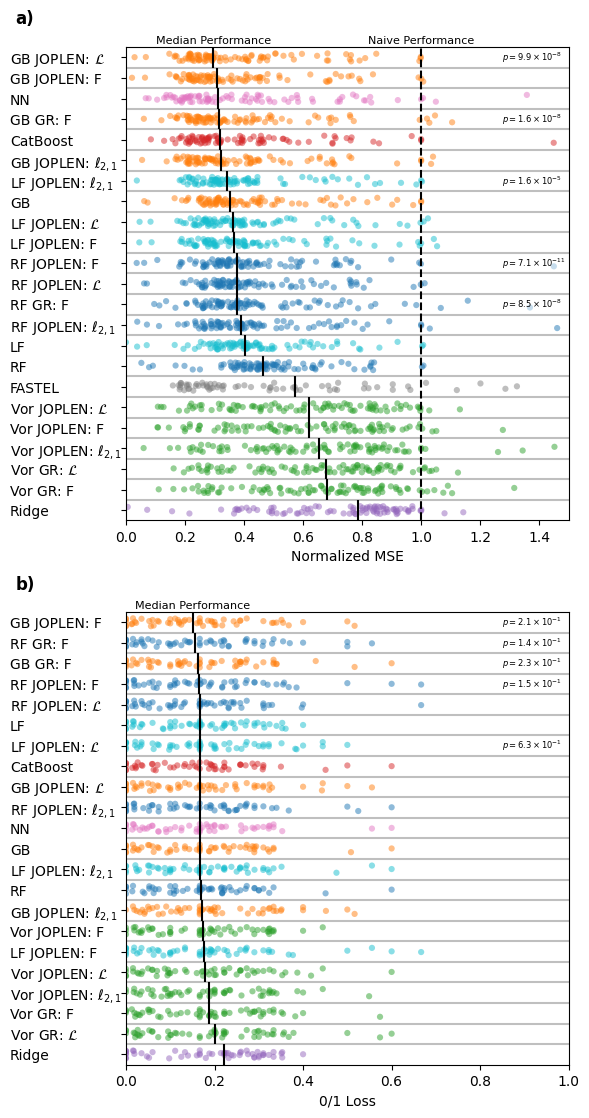

In [8]:
pval_methods = {
    "regr": [
        "jp_linear_gb_l2L2",  # jolpen GB
        "jp_const_gb_l2",  # GR GB
        "jp_linear_rf_l2",  # joplen RF
        "jp_const_rf_l2",  # GR RF
        "jp_linear_linforest_l21",  # joplen LF
    ],
    "class": [
        "jp_linear_gb_l2",  # jolpen GB
        "jp_const_gb_l2",  # jolpen GB
        "jp_const_rf_l2",  # GR GB
        "jp_linear_rf_l2",  # jolpen GB
        "jp_linear_linforest_l2L2",  # joplen LF
    ],
}

total_methods = len(reg_res["regr"]) + len(reg_res["class"])
fracs = [
    len(reg_res["regr"]) / total_methods,
    len(reg_res["class"]) / total_methods,
]

fig, axs = plt.subplots(2, 1, figsize=(6, total_methods / 4), height_ratios=fracs)

sorted_reg = scatter_pmlb("regr", axs[0])
sorted_class = scatter_pmlb("class", axs[1])

# print random text on each line
for ax, ds, pred_type in zip(axs, [sorted_reg, sorted_class], ["regr", "class"]):
    for i, method in enumerate(ds):
        if method not in pval_methods[pred_type]:
            continue

        pval_methods[pred_type].remove(method)

        base_method = method.split("_")[2]
        if base_method == "linforest":
            base_method = "lf"
        p_val = compare_methods(method, base_method, pred_type)
        mantisa, expo = f"{p_val:.1e}".split("e")
        mantisa = float(mantisa)
        expo = int(expo)
        ax.text(
            ax.get_xlim()[-1] * 0.85,
            i,
            f"$p = {mantisa:.1f} \\times 10^{{{expo}}}$",
            ha="left",
            va="center",
            fontsize=6,
            bbox=dict(boxstyle="square,pad=0", fc=(1, 1, 1, 0.5), ec="none"),
        )

    assert len(pval_methods[pred_type]) == 0, pval_methods[pred_type]

axs[0].text(
    -0.25, 1.05, "a)", transform=axs[0].transAxes, fontsize=12, fontweight="bold"
)
axs[1].text(
    -0.25, 1.05, "b)", transform=axs[1].transAxes, fontsize=12, fontweight="bold"
)

plt.tight_layout()

plt.savefig(PLOT_PATH / "paper_strip.pdf")

In [9]:
# Regression: Global refinement
print(f'GB: {compare_methods("jp_const_gb_l2", "gb", "regr"):.4e}')
print(f'RF: {compare_methods("jp_const_rf_l2", "rf", "regr"):.4e}')

GB: 1.6276e-08
RF: 8.5044e-08


In [10]:
# Regression: JOPLEn
print(f'GB: {compare_methods("jp_linear_gb_l2L2", "gb", "regr"):.4e}')
print(f'RF: {compare_methods("jp_linear_rf_l2L2", "rf", "regr"):.4e}')
print(f'CB: {compare_methods("jp_linear_gb_l2L2", "cb", "regr"):.4e}')
print(f'LF: {compare_methods("jp_linear_linforest_l2L2", "lf", "regr"):.4e}')

GB: 9.8930e-08
RF: 2.4386e-09
CB: 2.3471e-02
LF: 8.6114e-06


In [11]:
# Classification: JOPLEn
print(f'GB: {compare_methods("jp_linear_gb_l2L2", "gb", "class"):.4e}')

GB: 3.3356e-01


/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


##### Plot 2: Synthetic nuclear norm performance

In [12]:
n_points = 10000
n_train_points = 100
n_cells = 5
n_partitions = 20

np.random.seed(0)

x = np.random.uniform(-1, 1, (n_points, 2))
y = np.sin(np.pi * (x[:, 0] + x[:, 1])) + np.random.normal(0, 0.2, n_points)

x_train = x[:n_train_points]
y_train = y[:n_train_points, None]

x_test = x[n_train_points:]
y_test = y[n_train_points:, None]

In [13]:
# Using the f-norm with linear cells
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    rescale=False,
    regularizers=[
        SquaredFNorm(1e-3),
    ],
)

history = model.fit(x_train, y_train, verbose=False)

y_pred_l2 = model.predict(x_test)

print("L2 error:", np.mean((y_pred_l2 - y_test) ** 2))

L2 error: 0.29698666195929035


In [14]:
# using the nuclear norm with linear cells
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        NuclearNorm(lam=4.7e-2),
    ],
)

history = model.fit(x_train, y_train)

y_pred_nn = model.predict(x_test)

print("NN error:", np.mean((y_pred_nn - y_test) ** 2))

NN error: 0.14845475048983198


In [15]:
# using gradient boosting
model = LGBMRegressor(
    seed=0,
    verbose=-1,
    n_estimators=n_partitions,
    num_leaves=n_cells,
)

model.fit(x_train, y_train.flatten())

y_pred_lgbm = model.predict(x_test)[:, None]

print("LGBM error:", np.mean((y_pred_lgbm - y_test) ** 2))

LGBM error: 0.4578665424466753


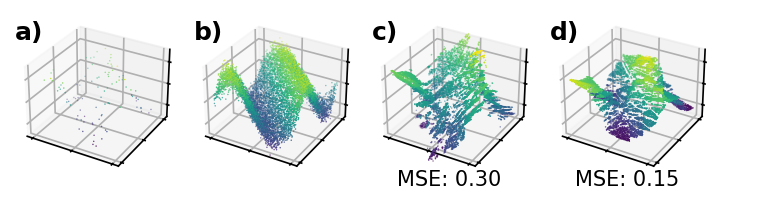

F-Norm Penalty Loss:       0.2970
Nuclear Norm Penalty Loss: 0.1485
LGBM Loss:                 0.4579


In [16]:
# Create a figure and a grid layout with 1 row and 2 columns
fig = plt.figure(dpi=150, figsize=(6, 2))

# Add the first subplot
axs = [fig.add_subplot(141, projection="3d")]
axs += [
    fig.add_subplot(
        140 + i, projection="3d", sharex=axs[0], sharey=axs[0], sharez=axs[0]
    )
    for i in range(2, 5)
]

shared_params = {
    "s": 0.5,
    "edgecolor": "none",
}

axs[0].scatter(
    x_train[:, 0],
    x_train[:, 1],
    y_train,
    c=y_train,
    **shared_params,
)

axs[1].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_test,
    c=y_test,
    **shared_params,
)

axs[2].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_l2,
    c=y_pred_l2,
    **shared_params,
)

axs[3].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_nn,
    c=y_pred_nn,
    **shared_params,
)

axs[0].set_zlim(-1.5, 1.5)


for ax, char in zip(axs, "abcd"):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.text(
        0, 0, 23, f"{char})", transform=ax.transAxes, fontsize=12, fontweight="bold"
    )

for ax, pred in zip(axs[2:], [y_pred_l2, y_pred_nn]):
    score = mean_squared_error(pred, y_test)
    ax.text(
        8, 4, 0, f"MSE: {score:.2f}", transform=ax.transAxes, ha="center", va="center"
    )


plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig(PLOT_PATH / "synthetic_nn.pdf", bbox_inches="tight")

plt.show()

print(f"F-Norm Penalty Loss:       {np.mean((y_test - y_pred_l2) ** 2):.4f}")
print(f"Nuclear Norm Penalty Loss: {np.mean((y_test - y_pred_nn) ** 2):.4f}")
print(f"LGBM Loss:                 {np.mean((y_test - y_pred_lgbm) ** 2):.4f}")

##### Plot 3: Multitask selection performance

In [17]:
# load data
def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    bouts_res = pd.read_csv(path / "bouts.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    # penalty mask
    bouts_path = path / "bouts"
    bouts_core = np.load(bouts_path / "univ.npy")
    bouts_task = np.load(bouts_path / "task.npy")

    return (
        jp_res,
        dl_res,
        bouts_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
        bouts_core,
        bouts_task,
    )

In [18]:
(
    sarcos_jp_res,
    sarcos_dl_res,
    sarcos_bouts_res,
    sarcos_dummy_results,
    sarcos_linear_results,
    sarcos_gb_results,
    sarcos_jp_core,
    sarcos_jp_task,
    sarcos_dl_core,
    sarcos_dl_task,
    sarcos_bouts_univ,
    sarcos_bouts_task,
) = load_results("sarcos")

(
    nano_jp_res,
    nano_dl_res,
    nano_bouts_res,
    nano_dummy_results,
    nano_linear_results,
    nano_gb_results,
    nano_jp_core,
    nano_jp_task,
    nano_dl_core,
    nano_dl_task,
    nano_bouts_univ,
    nano_bouts_task,
) = load_results("nanoparticle")

In [19]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(core_weights, task_weights, exclude_bias, axs=None):
    if exclude_bias:
        core_weights = core_weights[:, :-1]
        task_weights = task_weights[:, :-1]

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    # make the background white
    core_weights[core_weights == 0] = np.nan
    task_weights[task_weights == 0] = np.nan

    if axs is None:
        _, axs = plt.subplots(2, 1, figsize=(8, 3), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[1].matshow(task_weights, **params)

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    axs2 = axs[1].twiny()
    axs2.spines["top"].set_position(("axes", -0.1))
    axs2.tick_params("both", length=0, width=0, which="minor")
    axs2.xaxis.set_ticks_position("top")
    ticks = np.arange(n_tasks + 1) * n_cells
    axs2.set_xticks(ticks)
    axs2.set_xticklabels([])
    halfway_points = (ticks[1:] + ticks[:-1]) / 2
    axs2.xaxis.set_minor_locator(plt.FixedLocator(halfway_points))
    axs2.xaxis.set_minor_formatter(
        plt.FuncFormatter(lambda x, _: f"T{int(x / n_cells + 1)}")
    )
    axs2.tick_params(axis="x", which="minor", pad=-15)  # Increase pad for more offse

    for ax in axs:
        ax.set_xticks([])

    axs[0].set_ylabel("Common ($\\mathbf{C}$)")
    axs[1].set_ylabel("Task-specific ($\\mathbf{T}$)")

    axs[1].set_xlabel("Index of weights", labelpad=25)

    return ax

In [20]:
def count_n_feats(core_mask, task_mask):
    task_mask = task_mask & ~core_mask[None, :]

    n_core_feats = np.sum(core_mask)
    n_task_feats = np.sum(task_mask, axis=1)

    return n_core_feats, n_task_feats


def jp_n_feats(core_weights, task_weights):
    core_mask = np.linalg.norm(core_weights[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(task_weights[:, :-1], axis=2) > 1e-4

    return count_n_feats(core_mask, task_mask)


def dl_n_feats(core_weights, task_weights):
    core_mask = np.linalg.norm(core_weights.T, axis=0) > 1e-4
    task_mask = np.abs(task_weights.T) > 1e-4

    return count_n_feats(core_mask, task_mask)


def bouts_n_feats(univ_weights, task_weights):
    univ_mask = univ_weights == 0
    task_mask = (task_weights == 0) & ~univ_mask[None, :]

    return count_n_feats(univ_mask, task_mask)

In [21]:
n_feats = {
    "sarcos": {
        "dl": {
            "common": dl_n_feats(sarcos_dl_core, sarcos_dl_task)[0],
            "task": dl_n_feats(sarcos_dl_core, sarcos_dl_task)[1],
        },
        "jp": {
            "common": jp_n_feats(sarcos_jp_core, sarcos_jp_task)[0],
            "task": jp_n_feats(sarcos_jp_core, sarcos_jp_task)[1],
        },
        "bouts": {
            "common": bouts_n_feats(sarcos_bouts_univ, sarcos_bouts_task)[0],
            "task": bouts_n_feats(sarcos_bouts_univ, sarcos_bouts_task)[1],
        },
    },
    "nano": {
        "dl": {
            "common": dl_n_feats(nano_dl_core, nano_dl_task)[0],
            "task": dl_n_feats(nano_dl_core, nano_dl_task)[1],
        },
        "jp": {
            "common": jp_n_feats(nano_jp_core, nano_jp_task)[0],
            "task": jp_n_feats(nano_jp_core, nano_jp_task)[1],
        },
        "bouts": {
            "common": bouts_n_feats(nano_bouts_univ, nano_bouts_task)[0],
            "task": bouts_n_feats(nano_bouts_univ, nano_bouts_task)[1],
        },
    },
}

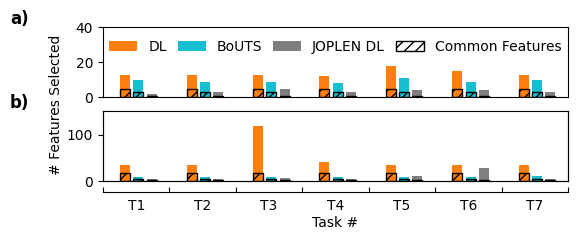

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(6, 2), sharey=False, sharex=False)

for i, (method, color) in enumerate(
    zip(["dl", "bouts", "jp"], ["tab:orange", "tab:cyan", "tab:grey"])
):
    for ax, ds_name in zip(axs, ["sarcos", "nano"]):
        n_common = n_feats[ds_name][method]["common"]
        n_tasks = len(n_feats[ds_name][method]["task"])

        # task-specific features
        ax.bar(
            np.arange(n_tasks) + i / 5,
            n_feats[ds_name][method]["task"] + n_common,
            bottom=n_common,
            width=0.15,
            color=[color] * n_tasks,
        )

        # common features
        ax.bar(
            np.arange(n_tasks) + i / 5,
            [n_common] * n_tasks,
            width=0.15,
            color=[color] * n_tasks,
            hatch="///",
            edgecolor="k",
        )

axs[0].set_ylim(0, 40)
axs[1].set_ylim(0, 150)

# add shared y label
axs[0].text(
    -0.1,
    -0.1,
    "# Features Selected",
    transform=axs[0].transAxes,
    rotation=90,
    va="center",
    ha="center",
)

for ax, letter in zip(axs, "ab"):
    ax.text(
        -0.2, 1.05, letter + ")", transform=ax.transAxes, fontsize=12, fontweight="bold"
    )

legend_handles = [
    Patch(facecolor="tab:orange", label="DL"),
    Patch(facecolor="tab:cyan", label="BoUTS"),
    Patch(facecolor="tab:grey", label="JOPLEN DL"),
    Patch(facecolor="w", edgecolor="k", hatch="///", label="Common Features"),
]

axs[0].legend(
    handles=legend_handles,
    loc="upper center",
    ncol=4,
    frameon=False,
    columnspacing=0.8,
)

for ax in axs:
    ax.set_xlim(-1 / 3, n_tasks - 1 / 3)
    ax.set_xticklabels([])
    ax.set_xticks([])


axs2 = axs[1].twiny()
axs2.spines["top"].set_position(("axes", -0.15))
axs2.tick_params("both", length=0, width=0, which="minor")
axs2.xaxis.set_ticks_position("top")
ticks = np.arange(n_tasks + 1)
axs2.set_xticks(ticks)
axs2.set_xticklabels([])
halfway_points = (ticks[1:] + ticks[:-1]) / 2
axs2.xaxis.set_minor_locator(plt.FixedLocator(halfway_points))
axs2.xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: f"T{int(x + 1)}"))
axs2.tick_params(axis="x", which="minor", pad=-15)

for ax in axs:
    ax.set_xticks([])

axs[1].set_xlabel("Task #", labelpad=25)

plt.savefig(PLOT_PATH / "features_selected.pdf", bbox_inches="tight")

In [23]:
# print the total number of features
for ds_name, ds_info in n_feats.items():
    print(ds_name)
    for method_name, info in ds_info.items():
        print(method_name, info["common"] + info["task"])

sarcos
dl [ 8  8  8  7 13 10  8]
jp [1 2 4 2 3 3 2]
bouts [7 6 6 5 8 6 7]
nano
dl [ 17  17 102  24  17  17  18]
jp [ 2  2  6  2  9 27  2]
bouts [6 5 6 5 5 6 7]


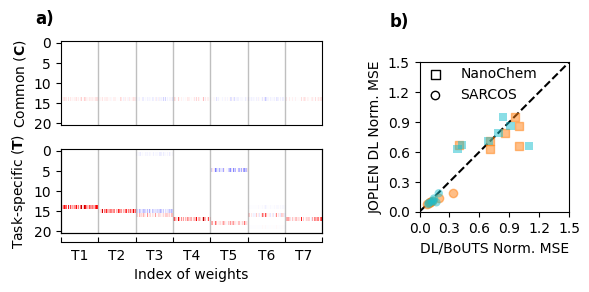

In [24]:
# Create figure and gridspec
fig = plt.figure(figsize=(6, 3.5))
gs = plt.GridSpec(2, 2, width_ratios=[1.75, 1], height_ratios=[1, 1])

# Plot in the first row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

plot_joplen_weights(sarcos_jp_core, sarcos_jp_task, exclude_bias=True, axs=[ax1, ax2])

# Square plot to the right
ax3 = fig.add_subplot(gs[:, 1])

ax3.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    marker="s",
    zorder=10,
    c="tab:orange",
    alpha=0.5,
)

ax3.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    marker="o",
    zorder=10,
    c="tab:orange",
    alpha=0.5,
)

ax3.scatter(
    nano_bouts_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    marker="s",
    zorder=10,
    c="tab:cyan",
    alpha=0.5,
    edgecolors="none",
)

ax3.scatter(
    sarcos_bouts_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    marker="o",
    zorder=10,
    c="tab:cyan",
    alpha=0.5,
    edgecolors="none",
)

# legend
(plt.scatter([], [], marker="s", facecolor="none", edgecolor="k", label="NanoChem"),)
(plt.scatter([], [], marker="o", facecolor="none", edgecolor="k", label="SARCOS"),)

x = np.linspace(0, 1.5, 6, endpoint=True)

ax3.plot(x, x, color="k", linestyle="--", zorder=0)

ax3.set_aspect("equal")

ax3.set_xticks(x)
ax3.set_yticks(x)

ax3.set_xlabel("DL/BoUTS Norm. MSE")
ax3.set_ylabel("JOPLEN DL Norm. MSE")
ax3.legend(frameon=False, bbox_to_anchor=(0.4, 0.85), loc="center")
ax3.set_xlim(0, 1.5)
ax3.set_ylim(0, 1.5)

# add subplot text
ax1.text(-0.1, 1.2, "a)", transform=ax1.transAxes, fontsize=12, fontweight="bold")
ax1.text(-0.2, 1.24, "b)", transform=ax3.transAxes, fontsize=12, fontweight="bold")

plt.tight_layout()

plt.savefig("plots/mt_perf.pdf", bbox_inches="tight")

plt.show()